# Twitter Sentiment Analysis - 04 Modeling

The stock market is a focus for investors to maximize their potential profits and consequently, the interest shown from the technical and financial sides in stock market prediction is always on the rise. However, stock market prediction is a problem known for its challenging nature due to its dependency on diverse factors that affect the market, these factors are unpredictable and cannot be taken into consideration such as political variables, and social media effects such as twitter on the stock market.

In this final part of this project, we will combine the stock data and its features, with vectorized representation of the tweets for the month of December 2022 to predict whether or not the adjusted closing price at the end of a trading-day is greater than or less than the previous trading-day. Models run are Logistic Regression, SVM, Random Forest, and Naive Bayes.

Two types of predictions: 
1. Using overall daily tweet sentiment scores to predict adjusted closing price
2. Using vectorized representation of tweets to predict adjusted closing price

**Link(s) to previous notebook(s)**: \
00_Historical_Data_2014: https://github.com/parisvu07/Springboard_Data_Science/tree/main/Capstone_2_Twitter_Sentiment_Analysis \
01_Data_Wrangling:
https://github.com/parisvu07/Springboard/blob/main/Capstone_2_Twitter_Sentiment_Analysis/01_Data_Wrangling.ipynb \
02_Exploratory_Data_Analysis: https://github.com/parisvu07/Springboard/blob/main/Capstone_2_Twitter_Sentiment_Analysis/02_Exploratory_Data_Analysis.ipynb \
03_Preprocessing_and_Training_Data: https://github.com/parisvu07/Springboard/blob/main/Capstone_2_Twitter_Sentiment_Analysis/03_Preprocessing_and_Training_Data.ipynb

Quick fix for "Unable to render rich display": copy and paste the notebook link to https://nbviewer.org

## 4.1 Importing

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from ast import literal_eval

#ignore warning messages to ensure clean outputs
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
import sklearn.metrics as metrics
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA

import gensim
from gensim.models.doc2vec import TaggedDocument
from gensim.models import Word2Vec
LabeledSentence = gensim.models.doc2vec.TaggedDocument
from tqdm import tqdm
import string
import spacy
np.random.seed(42)

from gensim.models import KeyedVectors 
from nltk import word_tokenize
from nltk.corpus import stopwords

In [2]:
#Importing stock data from notebook "02_Exploratory_Data_Analysis"
stock_data = pd.read_csv('03_stock_data.csv', encoding='latin-1')
stock_data = stock_data.set_index('Dates')
stock_data.head()

,Adj Close,stock_volume,%_change_Open,%_change_High,%_change_Low,%_change_Close,%_change_Volume,twitter_volume
Dates,,,,,,,,
2022-12-01,148.309998,71250400,NaN,NaN,NaN,NaN,NaN,1451
2022-12-02,147.809998,65447400,-1.518116,-0.757731,-0.654803,-0.337132,-8.144516,1551
2022-12-05,146.630005,68826400,1.240064,1.972972,0.082396,-0.798317,5.162925,1738
2022-12-06,142.910004,64727200,-0.473707,-2.398619,-2.641151,-2.536999,-5.955854,2072
2022-12-07,140.940002,69721100,-3.318151,-2.668030,-1.352874,-1.378491,7.715304,1912


In [3]:
#Importing tweet data from previous notebook "03_Preprocessing_and_Training_Data"
tweets_data = pd.read_csv('03_tweets_data.csv')
tweets_data = tweets_data.dropna()

In [4]:
#Importing merged dataframes from previous notebook "03_Preprocessing_and_Training_Data"
merged_dataframes = pd.read_csv('03_merged_dataframes.csv', lineterminator='\n')
merged_dataframes = merged_dataframes.set_index('Dates')
merged_dataframes.head()

,Adj Close,stock_volume,twitter_volume,likes,Subjectivity,Polarity,Sentiment,open_trend,high_trend,low_trend,close_trend,volume_trend,Sentiment_Score
Dates,,,,,,,,,,,,,
2022-12-01,148.309998,71250400,1451,3.358270,0.341031,0.166630,0.418668,0,0,0,0,0,Positive
2022-12-02,147.809998,65447400,1551,2.422508,0.336724,0.179263,0.434727,0,0,0,0,0,Positive
2022-12-05,146.630005,68826400,1738,16.589788,0.285005,0.119601,0.320138,1,1,1,0,1,Negative
2022-12-06,142.910004,64727200,2072,3.363636,0.308533,0.138852,0.345839,0,0,0,0,0,Negative
2022-12-07,140.940002,69721100,1912,3.910183,0.306545,0.141816,0.385379,0,0,0,0,1,Negative


## 4.2 Modeling

This is a classification problem, in unsupervised learning. Here we have used the following classification models:

Logistic Regression \
Random Forest \
Gradient Boosting \
Naive Bayes

Evaluating the performance of a model by training and testing on the same dataset can lead to the overfitting. Hence the model evaluation is based on splitting the dataset into train and validation set. But the performance of the prediction result depends upon the random choice of the pair of (train,validation) set. Inorder to overcome that, the Cross-Validation procedure is used where under the k-fold CV approach, the training set is split into k smaller sets, where a model is trained using k-1 of the folds as training data and the model is validated on the remaining part.

Classification/ Confusion Matrix: This matrix summarizes the correct and incorrect classifications that a classifier produced for a certain dataset. Rows and columns of the classification matrix correspond to the true and predicted classes respectively. The two diagonal cells (upper left, lower right) give the number of correct classifications, where the predicted class coincides with the actual class of the observation. The off diagonal cells gives the count of the misclassification. The classification matrix gives estimates of the true classification and misclassification rates.


Word2Vec is a collection of algorithms which can produce word embeddings. Word embeddings are vectors which describe the semantic meaning of words as points in space.



In [5]:
#loading pre-trained embedding
wv = KeyedVectors.load('glove-twitter-200.kv')

In [6]:
#Because we got rid of the array before saving in notebook 03, we need to vectorize the text again
def sent_vec(sent):
    vector_size = wv.vector_size
    wv_res = np.zeros(vector_size)
    ctr = 1
    for w in sent:
        if w in wv:
            ctr +=1
            wv_res += wv[w]
    wv_res = wv_res/ctr
    return wv_res

tweets_data['vec'] = tweets_data['tweet_lemmatized'].apply(sent_vec)
tweets_data = tweets_data[['Dates', 'Sentiment', 'clean_text', 'tweet_lemmatized', 'vec']]

tweets_data.head()

,Dates,Sentiment,clean_text,tweet_lemmatized,vec
0,2022-12-30,1.0,new yearâ food tradition around the world,"['new', 'yearâ\x80\x99', 'food', 'tradition', ...","[0.018792242098632932, -0.049044443161359856, ..."
1,2022-12-30,1.0,entrie amp exit daily \ndi cord link belo...,"['entrie', 'amp', 'exit', 'daily', 'di', 'cord...","[0.021105272420890518, -0.0418300421547089, -0..."
2,2022-12-30,0.0,aapl m ft py t la amzn brk b\n\n,"['aapl', 'ft', 'py', 'la', 'amzn', 'brk', 'b']","[-0.06759836408309639, -0.04402014476860442, -..."
3,2022-12-30,1.0,the bigge t â and maybe the be t â financi...,"['bigge', 'â\x80\x94', 'maybe', 'â\x80\x94', '...","[0.044564239627447065, -0.03471527336776711, -..."
4,2022-12-30,1.0,chatroom interm of \n\nalert call analy i ...,"['chatroom', 'interm', 'alert', 'call', 'analy']","[0.02505414104089141, -0.14497853252622817, -0..."


word2vec can’t create a vector from a word that’s not in its vocabulary. Because of this, we need to specify “if word in model.vocab” when creating the full list of word vectors.

In [7]:
# Grab all the tweets
tweets = tweets_data['clean_text']
print(tweets.shape)

(117841,)


In [8]:
#Create a list of strings, where each string is a tweet
tweets_list = [tweet for tweet in tweets]

#Collapse the list of strings into a single long string for processing
big_tweet_string = ' '.join(tweets_list)

#Tokenize the string into words
from nltk.tokenize import word_tokenize
tokens = word_tokenize(big_tweet_string)

#Remove non-alphabetic tokens, such as punctuation
words = [word.lower() for word in tokens if word.isalpha()]

#Filter out stopwords
stop_words = set(stopwords.words('english'))

words = [word for word in words if not word in stop_words]

#Print first 10 words
words[:10]

['new',
 'food',
 'tradition',
 'around',
 'world',
 'entrie',
 'amp',
 'exit',
 'daily',
 'di']

In [9]:
#Filter the list of vectors to include only those that Word2Vec has a vector for
vector_list = [wv[word] for word in words if word in wv.key_to_index]

#Create a list of the words corresponding to these vectors
words_filtered = [word for word in words if word in wv.key_to_index]

#Zip the words together with their vector representations
word_vec_zip = zip(words_filtered, vector_list)

#Cast to a dict so we can turn it into a DataFrame
word_vec_dict = dict(word_vec_zip)
df = pd.DataFrame.from_dict(word_vec_dict, orient='index')
df.head()

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
new,0.275540,0.155050,-0.39506,0.350000,0.018967,-0.43623,0.65921,-0.176150,-0.282610,-0.508480,...,0.067459,-0.177820,0.049174,0.26724,-0.061817,0.34782,-0.583470,-0.300400,0.286120,-0.063445
food,-0.691750,-0.142590,0.38653,-0.231410,-0.204080,-0.21565,0.77839,0.002269,-0.072446,-0.601340,...,-0.250490,-0.336230,0.184910,-0.48235,0.314250,0.24499,-0.244040,0.080309,0.340600,0.704510
tradition,-0.468270,-0.077617,0.37846,0.035308,-0.092955,-0.27471,0.39512,-0.166380,0.125070,0.041850,...,0.383770,-0.020489,0.803810,-0.17868,0.054530,0.21030,0.703030,-0.295210,0.294710,-0.601420
around,-0.540240,-0.173280,0.49958,-0.219800,0.187340,0.45666,0.86513,-0.286110,-0.450310,0.468560,...,0.215700,0.204540,-0.503040,-0.14797,0.257760,0.26054,0.322950,0.189860,0.022764,0.073641
world,0.035771,0.629460,0.27443,-0.364550,0.391890,-0.41298,0.12398,-0.349950,0.277250,0.000376,...,0.433180,-0.230370,0.019838,-0.21725,0.168180,0.61857,0.009801,0.113410,0.029805,-0.619340


### 4.2.1 Dimensionality Reduction with t-SNE

In [10]:
#Initialize t-SNE
from sklearn.manifold import TSNE
tsne = TSNE(n_components = 2, init = 'random', random_state = 10, perplexity = 100)

#Use only 400 rows to shorten processing time
tsne_df = tsne.fit_transform(df[:400])

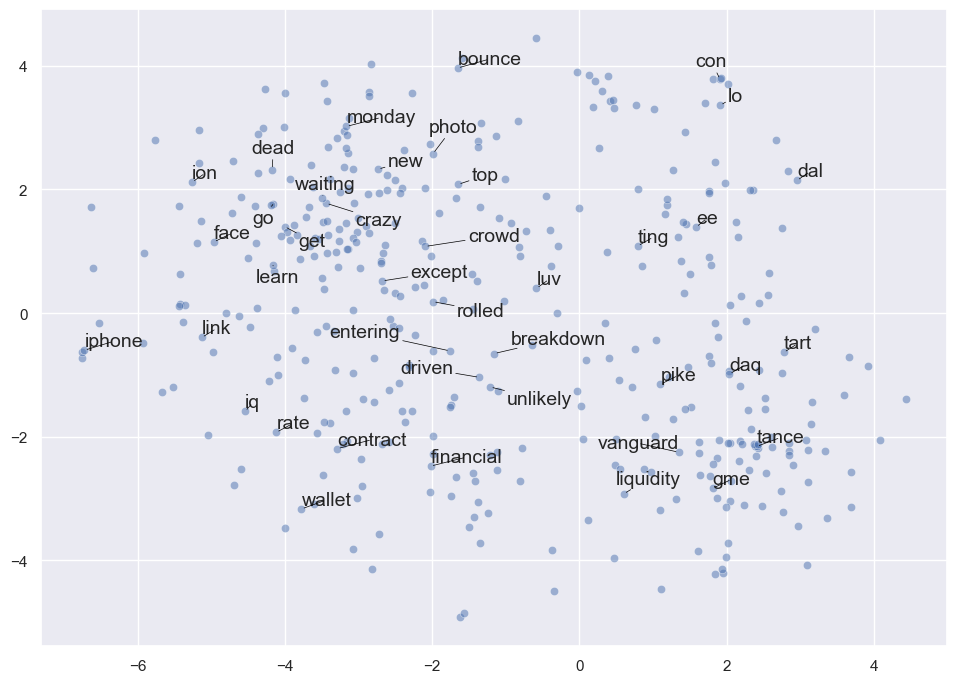

In [11]:
sns.set()
#Initialize figure
fig, ax = plt.subplots(figsize = (11.7, 8.27))
sns.scatterplot(tsne_df[:, 0], tsne_df[:, 1], alpha = 0.5)

#Import adjustText, initialize list of texts
from adjustText import adjust_text

texts = []
words_to_plot = list(np.arange(0, 400, 10))

#Append words to list
for word in words_to_plot:
    texts.append(plt.text(tsne_df[word, 0], tsne_df[word, 1], df.index[word], fontsize = 14))
    
#Plot text using adjust_text (because overlapping text is hard to read)
adjust_text(texts, force_points = 0.4, force_text = 0.4, 
            expand_points = (2,1), expand_text = (1,2),
            arrowprops = dict(arrowstyle = "-", color = 'black', lw = 0.5))

plt.show()

We see certain items clustering together. For example, we have movement terms in the upper left, we have corporate finance terms near the bottom.

### 4.2.2 Logistic Regression

In [12]:
X = tweets_data['vec'].to_list()
y = tweets_data['Sentiment'].to_list()

In [13]:
#Splitting data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [14]:
# Apply logistic regression model to training data
Logreg = LogisticRegression()
Logreg.fit(X_train, y_train)
    
# Predict using model
y_pred_lr = Logreg.predict(X_test)

In [15]:
cnf_matrix= confusion_matrix(y_test,y_pred_lr)
print(cnf_matrix)
Accuracy_lr = Logreg.score(X_test,y_test)

print(Accuracy_lr)

[[  10  832 1496]
 [  30 9938 2891]
 [  19 2503 5850]]
0.6702872417158131


**Accuracy** tells you how many times the ML model was correct overall. 

**Precision**: The number of instances that are relevant, out of the total instances the model retrieved.
*How many retrieved items are relevant?*

**Recall**: The number of instances which the model correctly identified as relevant out of the total relevant instances.
*How many relevant items are retrieved?*

**Recall or Precision?**
It depends on the context and the specific use case of the sentiment analysis model. In general, if the goal of the sentiment analysis model is to identify all instances of negative sentiment in a dataset, regardless of false positive predictions, then recall would be the priority. However, if the goal is to ensure a high level of accuracy in sentiment predictions, such that false positive predictions are minimized, then precision would be the priority.

In our capstone, we value high level of accuracy, hence precision is chosen.

In [16]:
accuracy_score_lr = metrics.accuracy_score(y_test, y_pred_lr)
precision_score_lr = metrics.precision_score(y_test, y_pred_lr, average='micro')
recall_score_lr = metrics.recall_score(y_test, y_pred_lr, average='micro')                                           
                                           
print("Logistic Regression Accuracy:" + str(accuracy_score_lr))
print("Logistic Regression Precision:" + str(precision_score_lr))
print("Logistic Regression Recall:" + str(recall_score_lr))

Logistic Regression Accuracy:0.6702872417158131
Logistic Regression Precision:0.6702872417158131
Logistic Regression Recall:0.6702872417158131


In [17]:
cv_scores_test= cross_val_score(Logreg,X_test,y_test,cv=5,scoring='accuracy',error_score="raise")
cv_scores_train= cross_val_score(Logreg,X_train,y_train,cv=5,scoring='accuracy',error_score="raise")
print(cv_scores_test)
cv_scores_lr_test= cv_scores_test.mean()
cv_scores_lr_train= cv_scores_train.mean()
cv_scores_std_test_lr= cv_scores_test.std()
print ('Mean cross validation test score: ' +str(cv_scores_lr_test))
print ('Mean cross validation train score: ' +str(cv_scores_lr_train))
print ('Standard deviation in cv test scores: ' +str(cv_scores_std_test_lr))

[0.66758591 0.67055579 0.66546457 0.67331353 0.67515383]
Mean cross validation test score: 0.6704147286308796
Mean cross validation train score: 0.666284826470299
Standard deviation in cv test scores: 0.00356056954933553


### 4.2.3 Random Forest (RF)

In [18]:
from sklearn.ensemble import RandomForestClassifier

#Apply RF to the training data:

rf = RandomForestClassifier(bootstrap=True,n_estimators=100,criterion='entropy')
rf.fit(X_train, y_train)

#Predict using the model:

y_predict_rf = rf.predict(X_test)

#Confusion matrix:

cnf_matrix = confusion_matrix(y_test, y_predict_rf)
print(cnf_matrix)
Accuracy_rf=rf.score(X_test,y_test)
print(Accuracy_rf)

[[  513   808  1017]
 [    6 11668  1185]
 [    6  1674  6692]]
0.8007552293266579


In [19]:
accuracy_score_rf = metrics.accuracy_score(y_test, y_predict_rf)
precision_score_rf = metrics.precision_score(y_test, y_predict_rf, average='micro')
recall_score_rf = metrics.recall_score(y_test, y_predict_rf, average='micro')                                           
                                           
print("Random Forest Accuracy:" + str(accuracy_score_rf))
print("Random Forest Precision:" + str(precision_score_rf))
print("Random Forest Recall:" + str(recall_score_rf))

Random Forest Accuracy:0.8007552293266579
Random Forest Precision:0.8007552293266579
Random Forest Recall:0.8007552293266579


In [20]:
cv_scores_test= cross_val_score(rf,X_test,y_test,cv=5,scoring='accuracy',error_score="raise")
cv_scores_train= cross_val_score(rf,X_train,y_train,cv=5,scoring='accuracy',error_score="raise")
print(cv_scores_test)
cv_scores_rf_test= cv_scores_test.mean()
cv_scores_rf_train= cv_scores_train.mean()
cv_scores_std_rf= cv_scores_test.std()
print ('Mean cross validation test score: ' +str(cv_scores_rf_test))
print ('Mean cross validation train score: ' +str(cv_scores_rf_train))
print ('Standard deviation in cv scores: ' +str(cv_scores_std_rf))

[0.77365295 0.78192618 0.76941027 0.76941027 0.76808827]
Mean cross validation test score: 0.7724975854164826
Mean cross validation train score: 0.7904043428016994
Standard deviation in cv scores: 0.005074216584768982


### 4.2.4 Gradient Boosting

In [21]:
from sklearn.ensemble import ExtraTreesClassifier, GradientBoostingClassifier
gbc = GradientBoostingClassifier(subsample=0.8, learning_rate=0.05 , n_estimators=160, random_state=5, max_depth=9, max_leaf_nodes=100)
gbc.fit(X_train, y_train)

#Predict using the model:

y_predict_gbc = gbc.predict(X_test)

#Confusion matrix:

cnf_matrix = confusion_matrix(y_test, y_predict_gbc)
print(cnf_matrix)
Accuracy_gbc=gbc.score(X_test,y_test)
print(Accuracy_gbc)

[[  404   752  1182]
 [   21 11367  1471]
 [   26  1604  6742]]
0.7854809283380711


In [22]:
accuracy_score_gb = metrics.accuracy_score(y_test, y_predict_gbc)
precision_score_gb = metrics.precision_score(y_test, y_predict_gbc, average='micro')
recall_score_gb = metrics.recall_score(y_test, y_predict_gbc, average='micro')                                           
                                           
print("Gradient Boosting Accuracy:" + str(accuracy_score_gb))
print("Gradient Boosting Precision:" + str(precision_score_gb))
print("Gradient Boosting Recall:" + str(recall_score_gb))

Gradient Boosting Accuracy:0.7854809283380711
Gradient Boosting Precision:0.7854809283380711
Gradient Boosting Recall:0.7854809283380711


In [23]:
cv_scores_test= cross_val_score(gbc,X_test,y_test,cv=5,scoring='accuracy',error_score="raise")
cv_scores_train= cross_val_score(gbc,X_train,y_train,cv=5,scoring='accuracy',error_score="raise")
print(cv_scores_test)
cv_scores_gbc_test= cv_scores_test.mean()
cv_scores_gbc_train= cv_scores_train.mean()
cv_scores_std_gbc= cv_scores_test.std()
print ('Mean cross validation test score: ' +str(cv_scores_gbc_test))
print ('Mean cross validation train score: ' +str(cv_scores_gbc_train))
print ('Standard deviation in cv scores: ' +str(cv_scores_std_gbc))

[0.77619856 0.77471362 0.77471362 0.76559185 0.7687248 ]
Mean cross validation test score: 0.771988490657774
Mean cross validation train score: 0.781568196565342
Standard deviation in cv scores: 0.004102338941703982


### 4.2.5 Naive Bayes

In [24]:
from sklearn.naive_bayes import GaussianNB
nb = GaussianNB()
nb.fit(X_train,y_train)

#Predict using the model:

y_predict_nb=nb.predict(X_test)

#Confusion matrix:

cnf_matrix = confusion_matrix(y_test, y_predict_nb)
print(cnf_matrix)
Accuracy_nb=nb.score(X_test,y_test)
print(Accuracy_nb)

[[1678  135  525]
 [4508 5427 2924]
 [4792  660 2920]]
0.4253468539182825


In [25]:
accuracy_score_nb = metrics.accuracy_score(y_test, y_predict_nb)
precision_score_nb = metrics.precision_score(y_test, y_predict_nb, average='micro')
recall_score_nb = metrics.recall_score(y_test, y_predict_nb, average='micro')                                           
                                           
print("Naive Bayes Accuracy:" + str(accuracy_score_nb))
print("Naive Bayes Precision:" + str(precision_score_nb))
print("Naive Bayes Recall:" + str(recall_score_nb))

Naive Bayes Accuracy:0.4253468539182825
Naive Bayes Precision:0.4253468539182825
Naive Bayes Recall:0.4253468539182825


In [26]:
cv_scores_test= cross_val_score(nb,X_test,y_test,cv=5,scoring='accuracy',error_score="raise")
cv_scores_train= cross_val_score(nb,X_train,y_train,cv=5,scoring='accuracy',error_score="raise")
print(cv_scores_test)
cv_scores_nb_test= cv_scores_test.mean()
cv_scores_nb_train= cv_scores_train.mean()
cv_scores_std_nb= cv_scores_test.std()
print ('Mean cross validation test score: ' +str(cv_scores_nb_test))
print ('Mean cross validation train score: ' +str(cv_scores_nb_train))
print ('Standard deviation in cv scores: ' +str(cv_scores_std_nb))

[0.42660161 0.40857022 0.37675011 0.40241833 0.40292807]
Mean cross validation test score: 0.40345366686768314
Mean cross validation train score: 0.4281654580465162
Standard deviation in cv scores: 0.015977701892214577


## 4.3 Models Comparison

In [27]:
myLabels = [ 'Logistic Regression','Random Forest','Gradient Boost','Naive Bayes']
score_test= [cv_scores_lr_test,cv_scores_rf_test,cv_scores_gbc_test,cv_scores_nb_test]
score_train= [cv_scores_lr_train,cv_scores_rf_train,cv_scores_gbc_test,cv_scores_nb_train]
Precision_score = [precision_score_lr,precision_score_rf,precision_score_gb,precision_score_nb]

score_tab_acc = pd.DataFrame(list(zip(myLabels, Precision_score)), 
               columns =['Algorithm', 'Model precision score']) 

score_tab = pd.DataFrame(list(zip(myLabels, score_train, score_test)), 
               columns =['Algorithm', 'Accuracy train score', 'Accuracy test score' ]) 
print(score_tab_acc)

score_tab

             Algorithm  Model precision score
0  Logistic Regression               0.670287
1        Random Forest               0.800755
2       Gradient Boost               0.785481
3          Naive Bayes               0.425347


,Algorithm,Accuracy train score,Accuracy test score
0,Logistic Regression,0.666285,0.670415
1,Random Forest,0.790404,0.772498
2,Gradient Boost,0.771988,0.771988
3,Naive Bayes,0.428165,0.403454


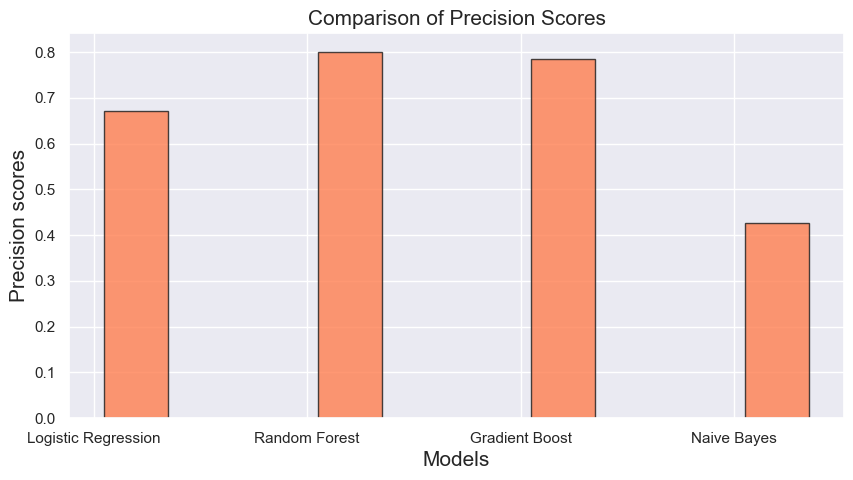

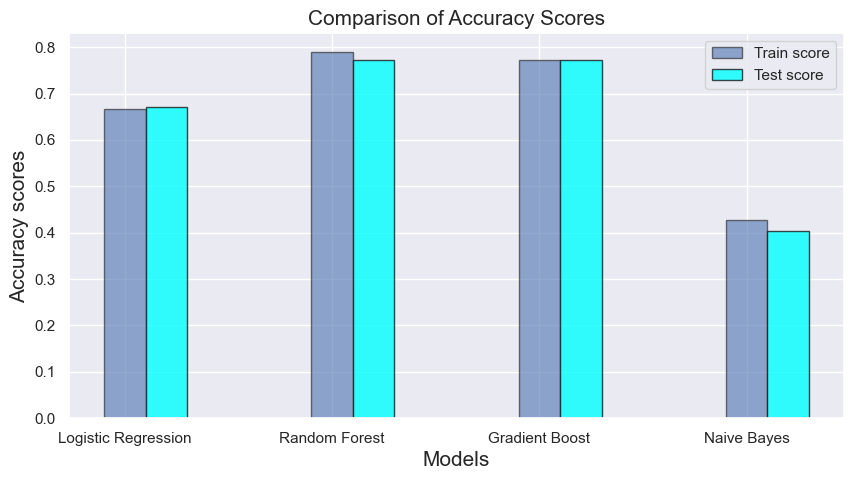

In [28]:
#plotting the Precision scores:

index=[1,2,3,4]
index_acc=[1.2,2.2,3.2,4.2]
plt.figure(figsize=(10,5))
plt.xlabel('Models',fontsize=15)
plt.ylabel ('Precision scores',fontsize=15)
plt.title('Comparison of Precision Scores',fontsize=15)
#patterns = [ "/"]
_=plt.bar(index_acc,Precision_score,color='coral',alpha=0.8,label='Precision score',edgecolor='k',width=0.3)
plt.xticks([1,2,3,4], myLabels)
#plt.legend()
plt.savefig("26.png")
plt.show()

#plotting and comparing Accuracy train/test scores:

index=[1,2,3,4]
index_acc=[1.2,2.2,3.2,4.2]
plt.figure(figsize=(10,5))
plt.xlabel('Models',fontsize=15)
plt.ylabel ('Accuracy scores',fontsize=15)
plt.title('Comparison of Accuracy Scores',fontsize=15)
_=plt.bar(index,score_train,color='b',alpha=0.6,label='Train score',edgecolor='k',width=0.2)
_=plt.bar(index_acc,score_test,color='cyan',alpha=0.8,label='Test score',edgecolor='k',width=0.2)
plt.xticks([1,2,3,4], myLabels)
plt.legend()
plt.savefig("27.png")
plt.show()

## 4.4 Random Search CV & Hyperparameter Tuning

### 4.4.1 Random Forest

In [33]:
from sklearn.model_selection import RandomizedSearchCV

rf = RandomForestClassifier(max_features='auto',random_state=1, n_jobs=-1)

rf_param = { "criterion" : ["gini", "entropy"], "min_samples_leaf" : [1, 5, 10], "min_samples_split" : [2, 4, 10,12,16], "n_estimators": [50, 100,400,700,1000]}

gs = RandomizedSearchCV(estimator=rf, param_distributions=rf_param, scoring='accuracy', cv=3, n_iter = 10, n_jobs=-1)

gs = gs.fit(X_train, y_train)

print(gs.best_estimator_) 
print(gs.best_score_)

RandomForestClassifier(criterion='entropy', min_samples_split=4,
                       n_estimators=700, n_jobs=-1, random_state=1)
0.7901709945689069


### Fitting the Random forest model with the optimal hyperparameters

In [37]:
rf = RandomForestClassifier(criterion='entropy', min_samples_split=4,
                       n_estimators=700, n_jobs=-1, random_state=1)
rf.fit(X_train, y_train)
y_predict_rf = rf.predict(X_test)

precision_score_rf = metrics.precision_score(y_test, y_predict_rf, average='micro')
cv = cross_val_score(rf, X_test, y_test,scoring='accuracy').mean()
print(precision_score_rf)
print(cv)

0.8011370868513725
0.7731340596393352


### 4.4.2 Gradient Boost

In [34]:
GB = GradientBoostingClassifier()
gb_param = {
        'loss' : ["deviance"],
        'n_estimators' : [100,200,300],
        'learning_rate': [0.1, 0.05, 0.01],
        'max_depth': [4, 8],
        'min_samples_leaf': [100,150],
        'max_features': [0.3, 0.1] 
        }

gsGB = RandomizedSearchCV(GB, param_distributions=gb_param, scoring='accuracy', cv=3, n_iter = 10, n_jobs= -1, verbose = 1)
gsGB.fit(X_train,y_train)
print(gsGB.best_estimator_)
print(gsGB.best_score_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
GradientBoostingClassifier(learning_rate=0.05, max_depth=8, max_features=0.3,
                           min_samples_leaf=150, n_estimators=300)
0.7804119993211134


### Fitting the Gradient Boost model with the optimal hyperparameters

In [57]:
GB= GradientBoostingClassifier(learning_rate=0.05, max_depth=8, max_features=0.3,
                           min_samples_leaf=150, n_estimators=300)
GB.fit(X_train, y_train)
y_predict_GB = GB.predict(X_test)

precision_score_GB = metrics.precision_score(y_test, y_predict_GB, average='micro')
cv_GB = cross_val_score(GB, X_test, y_test,scoring='accuracy').mean()
print(precision_score_GB)
print(cv_GB)

0.7859052144766431
0.7692731115634357


## 4.5 Conclusions

In order to predict the sentiment of each tweet, we have vectorized the tweets and applied classification machine learning models. Here we have used the following classification models:
 
- Logistic Regression
- Random Forest
- Gradient Boost
- Naive Bayes 

Evaluating the performance of a model by training and testing on the same dataset can lead to the overfitting. Hence the model evaluation is based on splitting the dataset into train and validation set. But the performance of the prediction result depends upon the random choice of the pair of (train,validation) set. Inorder to overcome that, the Cross-Validation procedure is used where under the k-fold CV approach, the training set is split into k smaller sets, where a model is trained using k-1 of the folds as training data and the model is validated on the remaining part.

We have evaluated each models in terms of model accuracy score, and 'precision' score for both the training and test data, and plotted them. The two best performing models are the Random forest and the Gradient boost. Both are the ensemble model, based on decision trees.

Next, we have carried out the Randomized Search CV for the hyperparameter tuning for both the models seperately. This step was the most time consuming one in terms of computation. (The RF model took much longer time). I originally attempted the exhaustive Grid Search CV, but with 

With the result of the optimized hyperparameters, we have again fitted the two models, and got the predictions seperately. Clearly, the model performance improved with the optimized parameters. The final precision scores for both RF and the GB are 0.801 and 0.785, respectively.

## 4.6 Possible Directions for the Future

There are possible alternative features to determine the sentiments of each tweet such as the change in stock price itself. Also, here we have used only the tweet data for the month of December 2022. The model can be improved, if we can use the data of the whole year of 2022.

Try to use more feature engineering. In this project, we have negnected the change in prices of the stock in the final models, although we had already engineered many features (stock_data.csv file).